# 문자 단위 RNN으로 이름 분류

18개 언어로 된 수천 개의 성을 훈련시키고, 철자에 따라 이름이 어떤 언어인지 예측합니다.  

```
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish
```

# 1.데이터 준비

# 1.데이터 준비
> [데이터 다운로드](https://download.pytorch.org/tutorial/data.zip)

데이터는 [Language].txt 라는 18개의 텍스트 파일로 구성되어 있습니다. 각 파일에는 한 줄에 하나의 이름이 포함되어 있으며, 대부분 로마자로 되어 있습니다.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

## 텍스트 표현
> 신경망으로 자연어 처리(NLP) 작업을 해결하려면 텍스트를 텐서로 표현하는 방법이 필요합니다. 컴퓨터는 이미 텍스트 문자를 ASCII 또는 UTF-8과 같은 인코딩을 사용하여 화면의 글꼴에 메핑되는 숫자로 나타내고 있습니다.

In [2]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# 유니코드 문자열을 ASCII로 변환, https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [3]:
print(f'all_letters: {all_letters}')
print(f'n_letters: {n_letters}')

all_letters: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
n_letters: 57


In [4]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


In [5]:
DATA_PATH = "/content/data/MyDrive/dev/2.deep learning/4. NLP/data"

In [7]:
# 각 언어의 이름 목록인 category_lines 사전 생성
category_lines = {}
all_categories = []

# 파일을 읽고 줄 단위로 분리
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in glob.glob(DATA_PATH+'names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines['Korean'][:5])

KeyError: ignored

In [9]:
category_lines.keys()

dict_keys([])

In [10]:
all_categories

[]

# 이름을 Tensor로 변경
> One-Hot vector를 사용하여 Tensor로 변경

In [11]:
'''
.. NOTE::
역자 주:  One-Hot 벡터는 언어를 다룰 때 자주 이용되며,
단어, 글자 등을 벡터로 표현할 때 단어, 글자 사이의 상관 관계를 미리 알 수 없을 경우,
One-Hot으로 표현하여 서로 직교한다고 가정하고 학습을 시작합니다.
이와 동일하게, 상관 관계를 알 수 없는 다른 데이터의 경우에도 One-Hot 벡터를 활용할 수 있습니다.
'''

import torch

# all_letters 로 문자의 주소 찾기, 예시 "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 검증을 위해서 한 개의 문자를 <1 x n_letters> Tensor로 변환
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# 한 줄(이름)을  <line_length x 1 x n_letters>,
# 또는 One-Hot 문자 벡터의 Array로 변경
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(all_letters)
print('-'*50)
print(letterToTensor('e'))
print('-'*50)
print(lineToTensor('Jones').shape) 

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
--------------------------------------------------
tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
--------------------------------------------------
torch.Size([5, 1, 57])


# 2.네트워크 생성

# RNN(Recurrent Neural Networks)
- RNN이란 Recurrent Neural Networks의 약자로, 순환 신경망을 뜻합니다. 순환 신경망이라는 이름은 입력받는 신호의 길이가 한정되지 않은 동적 데이터를 처리한다는 점에서 붙여진 이름입니다.

- RNN은 입력과 출력을 시퀀스 단위로 처리합니다.(시퀀스란 문장 같은 단어가 나열된 것을 뜻합니다.)  

In [12]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden  

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)  

In [13]:
print(f'n_letters: {n_letters} / n_categories: {n_categories}')

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
rnn

n_letters: 57 / n_categories: 0


/usr/local/lib/python3.9/dist-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=0, bias=True)
  (softmax): LogSoftmax(dim=1)
)

이 네트워크의 한 단계를 실행하려면 입력(현재 문자 Tensor)과 이전의 은닉 상태(처음에는 0으로 초기화)를 전달해야 합니다.    
출력(각 언어의 확률)과 다음 은닉 상태(다음 단계를 위해 유지)를 돌려받습니다.

In [14]:
input = letterToTensor('A')
hidden = rnn.initHidden()

output, next_hidden = rnn(input, hidden)

In [15]:
print(f'{next_hidden.shape}')
next_hidden

torch.Size([1, 128])


tensor([[-0.1088, -0.0023, -0.0133,  0.0495,  0.0925, -0.0586,  0.0171,  0.0337,
          0.0222,  0.0015,  0.0291, -0.1046, -0.0781,  0.0232, -0.0533,  0.0506,
          0.0346, -0.0495,  0.0246,  0.0075, -0.0523, -0.0188, -0.1277, -0.0112,
         -0.0290,  0.0766,  0.0602, -0.0108,  0.0025,  0.0396,  0.0069,  0.0369,
          0.0674,  0.0269, -0.0362,  0.0583,  0.0141, -0.0138,  0.0737, -0.0546,
         -0.0999,  0.0903,  0.0095,  0.0366,  0.0221, -0.0210,  0.0574, -0.0269,
         -0.0792,  0.0280,  0.1017,  0.0191,  0.0227,  0.0129,  0.0470, -0.1370,
         -0.0947,  0.0361, -0.0321, -0.1232,  0.0084,  0.1092, -0.0454, -0.0482,
         -0.0510,  0.0194, -0.0117, -0.0991,  0.0764, -0.0254,  0.0828,  0.1189,
         -0.0579, -0.0175,  0.0232,  0.0841,  0.0518, -0.0354, -0.0614,  0.1040,
          0.0503, -0.0400, -0.0123,  0.0733,  0.0965,  0.0491,  0.0370, -0.0434,
         -0.0351, -0.0676,  0.0796,  0.0808, -0.0156,  0.0354,  0.0439, -0.0094,
          0.1001, -0.0040, -

In [16]:
print(f'{next_hidden.shape}')
next_hidden

torch.Size([1, 128])


tensor([[-0.1088, -0.0023, -0.0133,  0.0495,  0.0925, -0.0586,  0.0171,  0.0337,
          0.0222,  0.0015,  0.0291, -0.1046, -0.0781,  0.0232, -0.0533,  0.0506,
          0.0346, -0.0495,  0.0246,  0.0075, -0.0523, -0.0188, -0.1277, -0.0112,
         -0.0290,  0.0766,  0.0602, -0.0108,  0.0025,  0.0396,  0.0069,  0.0369,
          0.0674,  0.0269, -0.0362,  0.0583,  0.0141, -0.0138,  0.0737, -0.0546,
         -0.0999,  0.0903,  0.0095,  0.0366,  0.0221, -0.0210,  0.0574, -0.0269,
         -0.0792,  0.0280,  0.1017,  0.0191,  0.0227,  0.0129,  0.0470, -0.1370,
         -0.0947,  0.0361, -0.0321, -0.1232,  0.0084,  0.1092, -0.0454, -0.0482,
         -0.0510,  0.0194, -0.0117, -0.0991,  0.0764, -0.0254,  0.0828,  0.1189,
         -0.0579, -0.0175,  0.0232,  0.0841,  0.0518, -0.0354, -0.0614,  0.1040,
          0.0503, -0.0400, -0.0123,  0.0733,  0.0965,  0.0491,  0.0370, -0.0434,
         -0.0351, -0.0676,  0.0796,  0.0808, -0.0156,  0.0354,  0.0439, -0.0094,
          0.1001, -0.0040, -

In [17]:
print(f'{output.shape}')
output

torch.Size([1, 0])


tensor([], size=(1, 0), grad_fn=<LogSoftmaxBackward0>)

In [23]:
top_n, top_i = output.topk(0)

top_n, top_i

(tensor([], size=(1, 0), grad_fn=<TopkBackward0>),
 tensor([], size=(1, 0), dtype=torch.int64))

In [24]:
category_i = top_i[0].item()

category_i, all_categories[category_i]

ValueError: ignored

#3. 학습

## 학습 준비
학습결과인 `output`을 해석할 수 있는 함수 생성

In [20]:
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i

In [25]:
print(categoryFromOutput(output))

RuntimeError: ignored

In [27]:
import random

def randomChoice(l):
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(5):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f'category = {category} / line = {line}')
    print(f'category_tensor = {category_tensor.shape} / line_tensor = {line_tensor.shape}')
    print('-'*70)


ValueError: ignored

### 네트워크 학습
학습 루프
1. 입력과 목표 Tensor 생성
2. 0으로 초기화 된 은닉 상태 생성
3. 각 문자 읽기
4. 다음 준자를 위한 은닉 상태 유지
5. 목표와 최종 출력 비교 
6. 역전파
7. 출력과 손실 반환 

In [28]:
criterion = nn.NLLLoss()

In [29]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)
  loss.backward()

  # 매개변수의 경사도에 학습률을 곱해서 그 매개변수의 값에 더합니다.
  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()  

In [30]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# 도식화를 위한 손실 추적
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # iter 숫자, 손실, 이름, 추측 화면 출력
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 현재 평균 손실을 전체 손실 리스트에 추가
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

ValueError: ignored

# 결과 확인

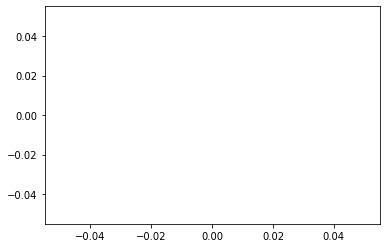

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# 4.결과 평가

네트워크(모델)가 다른 카테고리에서 얼마나 잘 작동하는지 보기 위해 모든 실제 언어(행)가 네트워크에서 어떤 언어로 추측(열)되는지 나타내는 `confusion matrix`를 만듭니다.   
`confusion matrix`를 계산하기 위해 `evaluate()`로 많으 수의 샘플을 네트워크에 실행합니다. (`evaluate()`는 `train()`에서 역전파를 빼면 동일합니다.)

In [ ]:
# 주어진 라인의 출력 반환
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [ ]:
# 혼란 행렬에서 정확한 추측을 추적
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# 예시 중 어떤 것이 정확히 예측되었는지 기록
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# 모든 행을 합계로 나누어 정규화
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# 도식 설정
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# 축 설정
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# 모든 tick에서 레이블 지정
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [ ]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [ ]:
predict('Dovesky')
predict('Jackson')
predict('Satoshi')